# Ставим завиcимости 

In [1]:
import $ivy.`org.apache.spark::spark-sql:3.1.1`
import $ivy.`org.apache.spark::spark-mllib:3.1.1`
import $ivy.`sh.almond::almond-spark:0.11.1`
import $ivy.`org.scalanlp::breeze:1.2`
import $ivy.`org.scalanlp::breeze-natives:1.2`
import $ivy.`org.scalanlp::breeze-viz:1.2`

import $ivy.$                                  

import $ivy.$                                    

import $ivy.$                               

import $ivy.$                         

import $ivy.$                                 

import $ivy.$                             

In [2]:
interp.repositories() ++= Seq(
  coursierapi.MavenRepository.of("https://dl.bintray.com/cibotech/public")
)

In [3]:
import $ivy.`com.cibo::evilplot-repl:0.7.1`

import $ivy.$                              

In [4]:
def showPlot(plot: com.cibo.evilplot.geometry.Drawable) =
  Image.fromRenderedImage(plot.asBufferedImage, format=Image.PNG)

defined function showPlot

In [5]:
import org.apache.log4j.{Level, Logger}
Logger.getLogger("org").setLevel(Level.OFF)

import org.apache.log4j.{Level, Logger}


# Запускаем Spark

In [6]:
import org.apache.spark.sql._

val spark = {
  NotebookSparkSession.builder()
    .master("local[*]")
    .getOrCreate()
}

Loading spark-stubs
Getting spark JARs
Creating SparkSession


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties


Spark UI

import org.apache.spark.sql._


spark: SparkSession = org.apache.spark.sql.SparkSession@19333bdc

# Читаем датасет

In [7]:
val raw_df = spark.read
    .option("header",true)
    .option("inferSchema",true)
    .csv("Dataset.csv")

csv at cmd6.sc:4

1 / 1

csv at cmd6.sc:4

1 / 1

raw_df: DataFrame = [likes: int, Checkins: int ... 26 more fields]

In [8]:
raw_df.printSchema()

root
 |-- likes: integer (nullable = true)
 |-- Checkins: integer (nullable = true)
 |-- Returns: integer (nullable = true)
 |-- Category: integer (nullable = true)
 |-- commBase: integer (nullable = true)
 |-- comm24: integer (nullable = true)
 |-- comm48: integer (nullable = true)
 |-- comm24_1: integer (nullable = true)
 |-- diff2448: integer (nullable = true)
 |-- baseTime: integer (nullable = true)
 |-- length: integer (nullable = true)
 |-- shares: integer (nullable = true)
 |-- hrs: integer (nullable = true)
 |-- sun_pub: integer (nullable = true)
 |-- mon_pub: integer (nullable = true)
 |-- tue_pub: integer (nullable = true)
 |-- wed_pub: integer (nullable = true)
 |-- thu_pub: integer (nullable = true)
 |-- fri_pub: integer (nullable = true)
 |-- sat_pub: integer (nullable = true)
 |-- sun_base: integer (nullable = true)
 |-- mon_base: integer (nullable = true)
 |-- tue_base: integer (nullable = true)
 |-- wed_base: integer (nullable = true)
 |-- thu_base: integer (nullable = 

# Выбираем колонку которую будем пердсказывать

In [9]:
val label = "output"

label: String = "output"

In [10]:
val columns_features = raw_df.drop(label).columns

columns_features: Array[String] = Array(
  "likes",
  "Checkins",
  "Returns",
  "Category",
  "commBase",
  "comm24",
  "comm48",
  "comm24_1",
  "diff2448",
  "baseTime",
  "length",
  "shares",
  "hrs",
  "sun_pub",
  "mon_pub",
  "tue_pub",
  "wed_pub",
  "thu_pub",
  "fri_pub",
  "sat_pub",
  "sun_base",
  "mon_base",
  "tue_base",
  "wed_base",
  "thu_base",
  "fri_base",
  "sat_base"
)

# Чистим датасет от строк с пустыми значениями

In [11]:
import org.apache.spark.sql.types.{StructField, StructType}
import org.apache.spark.sql.{DataFrame, SQLContext}
import org.apache.spark.{SparkConf, SparkContext}
import org.apache.spark.sql.functions.{col, udf}

import org.apache.spark.sql.types.{StructField, StructType}

import org.apache.spark.sql.{DataFrame, SQLContext}

import org.apache.spark.{SparkConf, SparkContext}

import org.apache.spark.sql.functions.{col, udf}

In [12]:
implicit class RichDF(val ds:DataFrame) {
    def showHTML(limit:Int = 20, truncate: Int = 20) = {
        import xml.Utility.escape
        val data = ds.take(limit)
        val header = ds.schema.fieldNames.toSeq        
        val rows: Seq[Seq[String]] = data.map { row =>
          row.toSeq.map { cell =>
            val str = cell match {
              case null => "null"
              case binary: Array[Byte] => binary.map("%02X".format(_)).mkString("[", " ", "]")
              case array: Array[_] => array.mkString("[", ", ", "]")
              case seq: Seq[_] => seq.mkString("[", ", ", "]")
              case _ => cell.toString
            }
            if (truncate > 0 && str.length > truncate) {
              // do not show ellipses for strings shorter than 4 characters.
              if (truncate < 4) str.substring(0, truncate)
              else str.substring(0, truncate - 3) + "..."
            } else {
              str
            }
          }: Seq[String]
        }

        publish.html(s""" <table>
                <tr>
                 ${header.map(h => s"<th>${escape(h)}</th>").mkString}
                </tr>
                ${rows.map { row =>
                  s"<tr>${row.map{c => s"<td>${escape(c)}</td>" }.mkString}</tr>"
                }.mkString}
            </table>
        """)        
    }
    
}

defined class RichDF

In [13]:
def setNullableStateForAllColumns( df: DataFrame, nullable: Boolean) : DataFrame = {
  // get schema
  val schema = df.schema
  // modify [[StructField] with name `cn`
  val newSchema = StructType(schema.map {
    case StructField( c, t, _, m) ⇒ StructField( c, t, nullable = nullable, m)
  })
  // apply new schema
  df.sqlContext.createDataFrame( df.rdd, newSchema )
}

defined function setNullableStateForAllColumns

In [14]:
val filterCond = raw_df.columns.map(x=>col(x).isNotNull).reduce(_ && _)
val df = setNullableStateForAllColumns(raw_df.filter(filterCond), false)

print(s"Размер датасета с пропусками: ${raw_df.count}")
print(s"Размер датасета без пропусков: ${df.count}")

count at cmd13.sc:4

1 / 1

count at cmd13.sc:4

1 / 1

Размер датасета с пропусками: 40949

count at cmd13.sc:5

1 / 1

count at cmd13.sc:5

1 / 1

Размер датасета без пропусков: 32544

filterCond: Column = ((((((((((((((((((((((((((((likes IS NOT NULL) AND (Checkins IS NOT NULL)) AND (Returns IS NOT NULL)) AND (Category IS NOT NULL)) AND (commBase IS NOT NULL)) AND (comm24 IS NOT NULL)) AND (comm48 IS NOT NULL)) AND (comm24_1 IS NOT NULL)) AND (diff2448 IS NOT NULL)) AND (baseTime IS NOT NULL)) AND (length IS NOT NULL)) AND (shares IS NOT NULL)) AND (hrs IS NOT NULL)) AND (sun_pub IS NOT NULL)) AND (mon_pub IS NOT NULL)) AND (tue_pub IS NOT NULL)) AND (wed_pub IS NOT NULL)) AND (thu_pub IS NOT NULL)) AND (fri_pub IS NOT NULL)) AND (sat_pub IS NOT NULL)) AND (sun_base IS NOT NULL)) AND (mon_base IS NOT NULL)) AND (tue_base IS NOT NULL)) AND (wed_base IS NOT NULL)) AND (thu_base IS NOT NULL)) AND (fri_base IS NOT NULL)) AND (sat_base IS NOT NULL)) AND (output IS NOT NULL))
df: DataFrame = [likes: int, Checkins: int ... 26 more fields]

In [15]:
df.printSchema()

root
 |-- likes: integer (nullable = false)
 |-- Checkins: integer (nullable = false)
 |-- Returns: integer (nullable = false)
 |-- Category: integer (nullable = false)
 |-- commBase: integer (nullable = false)
 |-- comm24: integer (nullable = false)
 |-- comm48: integer (nullable = false)
 |-- comm24_1: integer (nullable = false)
 |-- diff2448: integer (nullable = false)
 |-- baseTime: integer (nullable = false)
 |-- length: integer (nullable = false)
 |-- shares: integer (nullable = false)
 |-- hrs: integer (nullable = false)
 |-- sun_pub: integer (nullable = false)
 |-- mon_pub: integer (nullable = false)
 |-- tue_pub: integer (nullable = false)
 |-- wed_pub: integer (nullable = false)
 |-- thu_pub: integer (nullable = false)
 |-- fri_pub: integer (nullable = false)
 |-- sat_pub: integer (nullable = false)
 |-- sun_base: integer (nullable = false)
 |-- mon_base: integer (nullable = false)
 |-- tue_base: integer (nullable = false)
 |-- wed_base: integer (nullable = false)
 |-- thu_ba

In [16]:
val df_summary = df.summary()
df_summary.showHTML()

summary at cmd15.sc:1

1 / 1

summary at cmd15.sc:1

1 / 1

summary,likes,Checkins,Returns,Category,commBase,comm24,comm48,comm24_1,diff2448,baseTime,length,shares,hrs,sun_pub,mon_pub,tue_pub,wed_pub,thu_pub,fri_pub,sat_pub,sun_base,mon_base,tue_base,wed_base,thu_base,fri_base,sat_base,output
count,32544,32544,32544,32544,32544,32544,32544,32544,32544,32544,32544,32544,32544,32544,32544,32544,32544,32544,32544,32544,32544,32544,32544,32544,32544,32544,32544,32544
mean,1413566.6092367256,4958.88148352999,47644.64586406096,24.3375430186824,57.197117748279254,22.810041789577188,20.261369223205506,54.086252458210424,2.5486725663716814,35.19011184857424,158.10127826941985,125.44926868239921,23.744346116027533,0.1160889872173058,0.13034660766961653,0.16150442477876106,0.16998525073746312,0.14700098328416913,0.14629424778761063,0.12877949852507375,0.15065757128810225,0.08788102261553589,0.14420476892822026,0.1547136184857424,0.15923058013765978,0.15025811209439527,0.15305432645034414,7.415283923303835
stddev,7336572.166988181,20975.685602975693,118550.34982212083,19.920612722316402,138.53923968315553,77.38184875738618,72.34546916148204,129.72932293030507,95.1879066635169,20.911597883378022,348.0975608592928,1046.1339922717923,2.007766621686439,0.32033652210593183,0.336689549612527,0.3680012321203724,0.3756256125078691,0.35411233712718043,0.35340639299876286,0.33496087366667965,0.3577202811219888,0.2831261408260906,0.3513026412544962,0.3616370187650174,0.3658965923748769,0.3573297290842397,0.36004539006954295,35.322185312846436
min,36,0,0,1,0,0,0,0,-1366,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25%,43331,0,770,9,2,0,0,2,-6,17,39,2,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
50%,313452,0,9114,18,12,2,0,11,0,35,97,15,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
75%,1408791,148,53288,32,48,12,9,46,3,53,170,64,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
max,486972297,186370,6089942,106,2341,2079,1548,2184,2079,72,21480,144860,24,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1305


df_summary: DataFrame = [summary: string, likes: string ... 27 more fields]

In [17]:
import spark.implicits._
import scala.util.Try
import org.apache.spark.ml.linalg._
import org.apache.spark.ml.feature.VectorAssembler
import org.apache.spark.ml.stat.Correlation

import spark.implicits._

import scala.util.Try

import org.apache.spark.ml.linalg._

import org.apache.spark.ml.feature.VectorAssembler

import org.apache.spark.ml.stat.Correlation

In [18]:
val exprs = df.columns.map(c => col(c).cast("double"))

exprs: Array[Column] = Array(
  CAST(likes AS DOUBLE),
  CAST(Checkins AS DOUBLE),
  CAST(Returns AS DOUBLE),
  CAST(Category AS DOUBLE),
  CAST(commBase AS DOUBLE),
  CAST(comm24 AS DOUBLE),
  CAST(comm48 AS DOUBLE),
  CAST(comm24_1 AS DOUBLE),
  CAST(diff2448 AS DOUBLE),
  CAST(baseTime AS DOUBLE),
  CAST(length AS DOUBLE),
  CAST(shares AS DOUBLE),
  CAST(hrs AS DOUBLE),
  CAST(sun_pub AS DOUBLE),
  CAST(mon_pub AS DOUBLE),
  CAST(tue_pub AS DOUBLE),
  CAST(wed_pub AS DOUBLE),
  CAST(thu_pub AS DOUBLE),
  CAST(fri_pub AS DOUBLE),
  CAST(sat_pub AS DOUBLE),
  CAST(sun_base AS DOUBLE),
  CAST(mon_base AS DOUBLE),
  CAST(tue_base AS DOUBLE),
  CAST(wed_base AS DOUBLE),
  CAST(thu_base AS DOUBLE),
  CAST(fri_base AS DOUBLE),
  CAST(sat_base AS DOUBLE),
  CAST(output AS DOUBLE)
)

In [19]:
val df_double = df.select(exprs: _*)

df_double: DataFrame = [likes: double, Checkins: double ... 26 more fields]

In [20]:
val assembler = new VectorAssembler()
  .setInputCols(columns_features)
  .setOutputCol("features")

assembler: VectorAssembler = VectorAssembler: uid=vecAssembler_53db28982629, handleInvalid=error, numInputCols=27

In [21]:
val df_features = assembler.transform(df_double)

df_features: DataFrame = [likes: double, Checkins: double ... 27 more fields]

In [22]:
val Row(coeff1: Matrix) = Correlation.corr(df_features, "features").head

first at RowMatrix.scala:62

1 / 1

treeAggregate at Statistics.scala:58

1 / 1

first at RowMatrix.scala:442

1 / 1

treeAggregate at RowMatrix.scala:124

1 / 1

coeff1: Matrix = 1.0                     0.040137564380736644    ... (27 total)
0.040137564380736644    1.0                     ...
0.6278278844661094      0.15337897465130115     ...
-0.03279218953119031    -0.07020725164607754    ...
0.10025276983055322     0.09237381414133437     ...
0.07493402592164884     0.05868844832746428     ...
0.06772876928848309     0.06011471539696292     ...
0.09973968272660673     0.09522608581444941     ...
0.009440945832780127    0.0020211952350139683   ...
-0.008929110937885655   0.0049540057887329314   ...
-0.0017944676966280093  -0.0025950482814879675  ...
0.3415112787866649      0.04432388942967613     ...
-0.020968569277467587   -0.010102593128959877   ...
-0.004004162639530355   -0.0048009923399678816  ...
0.0027063813924104547   -0.018130810585776435   ...
0.011790101631194759    0.006480785109265317    ...
0.0027318646766279955   0.003669379717366586    ...
-0.006896171369131423   0.013340197235506666    ...
-0.011350005009850223   -0.011530037

In [23]:
val Row(coeff2: Matrix) = Correlation.corr(df_features, "features", "spearman").head

flatMap at SpearmanCorrelation.scala:48

1 / 1

mapPartitions at SpearmanCorrelation.scala:54

1 / 1

first at RowMatrix.scala:62

1 / 1

treeAggregate at Statistics.scala:58

1 / 1

first at RowMatrix.scala:442

1 / 1

treeAggregate at RowMatrix.scala:156

1 / 1

21/04/25 20:13:33 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/04/25 20:13:33 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


coeff2: Matrix = 1.0                     0.19176513195813522     ... (27 total)
0.19176513195813522     1.0                     ...
0.8212678867955855      0.13232855496450044     ...
-0.3936427688020219     0.05898008751315148     ...
0.5586026487997914      0.05732313313077851     ...
0.43489655507295044     0.03640593211655421     ...
0.29155813502133426     0.01606945977003434     ...
0.5577982386671035      0.057985255560984404    ...
-0.08771966819816797    -0.011572967331207428   ...
-0.01800508361286597    -0.006224827678467367   ...
0.06878349769746107     0.094957479038855       ...
0.5578894579825961      0.10637276257650845     ...
-0.10592316837871632    -0.005888342222886982   ...
0.006450640041419278    -0.024776200572208678   ...
-5.007974433510054E-4   -0.007980519672215938   ...
0.012349922413065657    0.007683578838915802    ...
0.016954113127148607    0.007854944157586263    ...
-0.014710876688621748   0.01201359867517025     ...
-0.016817136581767426   -0.006788218

Построим тепловую карту корреляции

In [24]:
import com.cibo.evilplot.geometry._
import com.cibo.evilplot.colors._
import com.cibo.evilplot.numeric.Point

import com.cibo.evilplot.geometry._

import com.cibo.evilplot.colors._

import com.cibo.evilplot.numeric.Point

In [25]:
def heatmapPlot ( matrix: Matrix ) : Drawable = {
    Align.right(
        matrix.colIter.toList.map(
            c=>{
              Align.bottom(
                 c.toArray.map(
                    e=>{
                        Rect(20, 20) filled RGB((255.0*e.abs).toInt, 126, 34)
                    }
                 ):_*
              ).reduce(_ beside _)   
            }
        ):_*
    ).reduce(_ above _)
}

defined function heatmapPlot

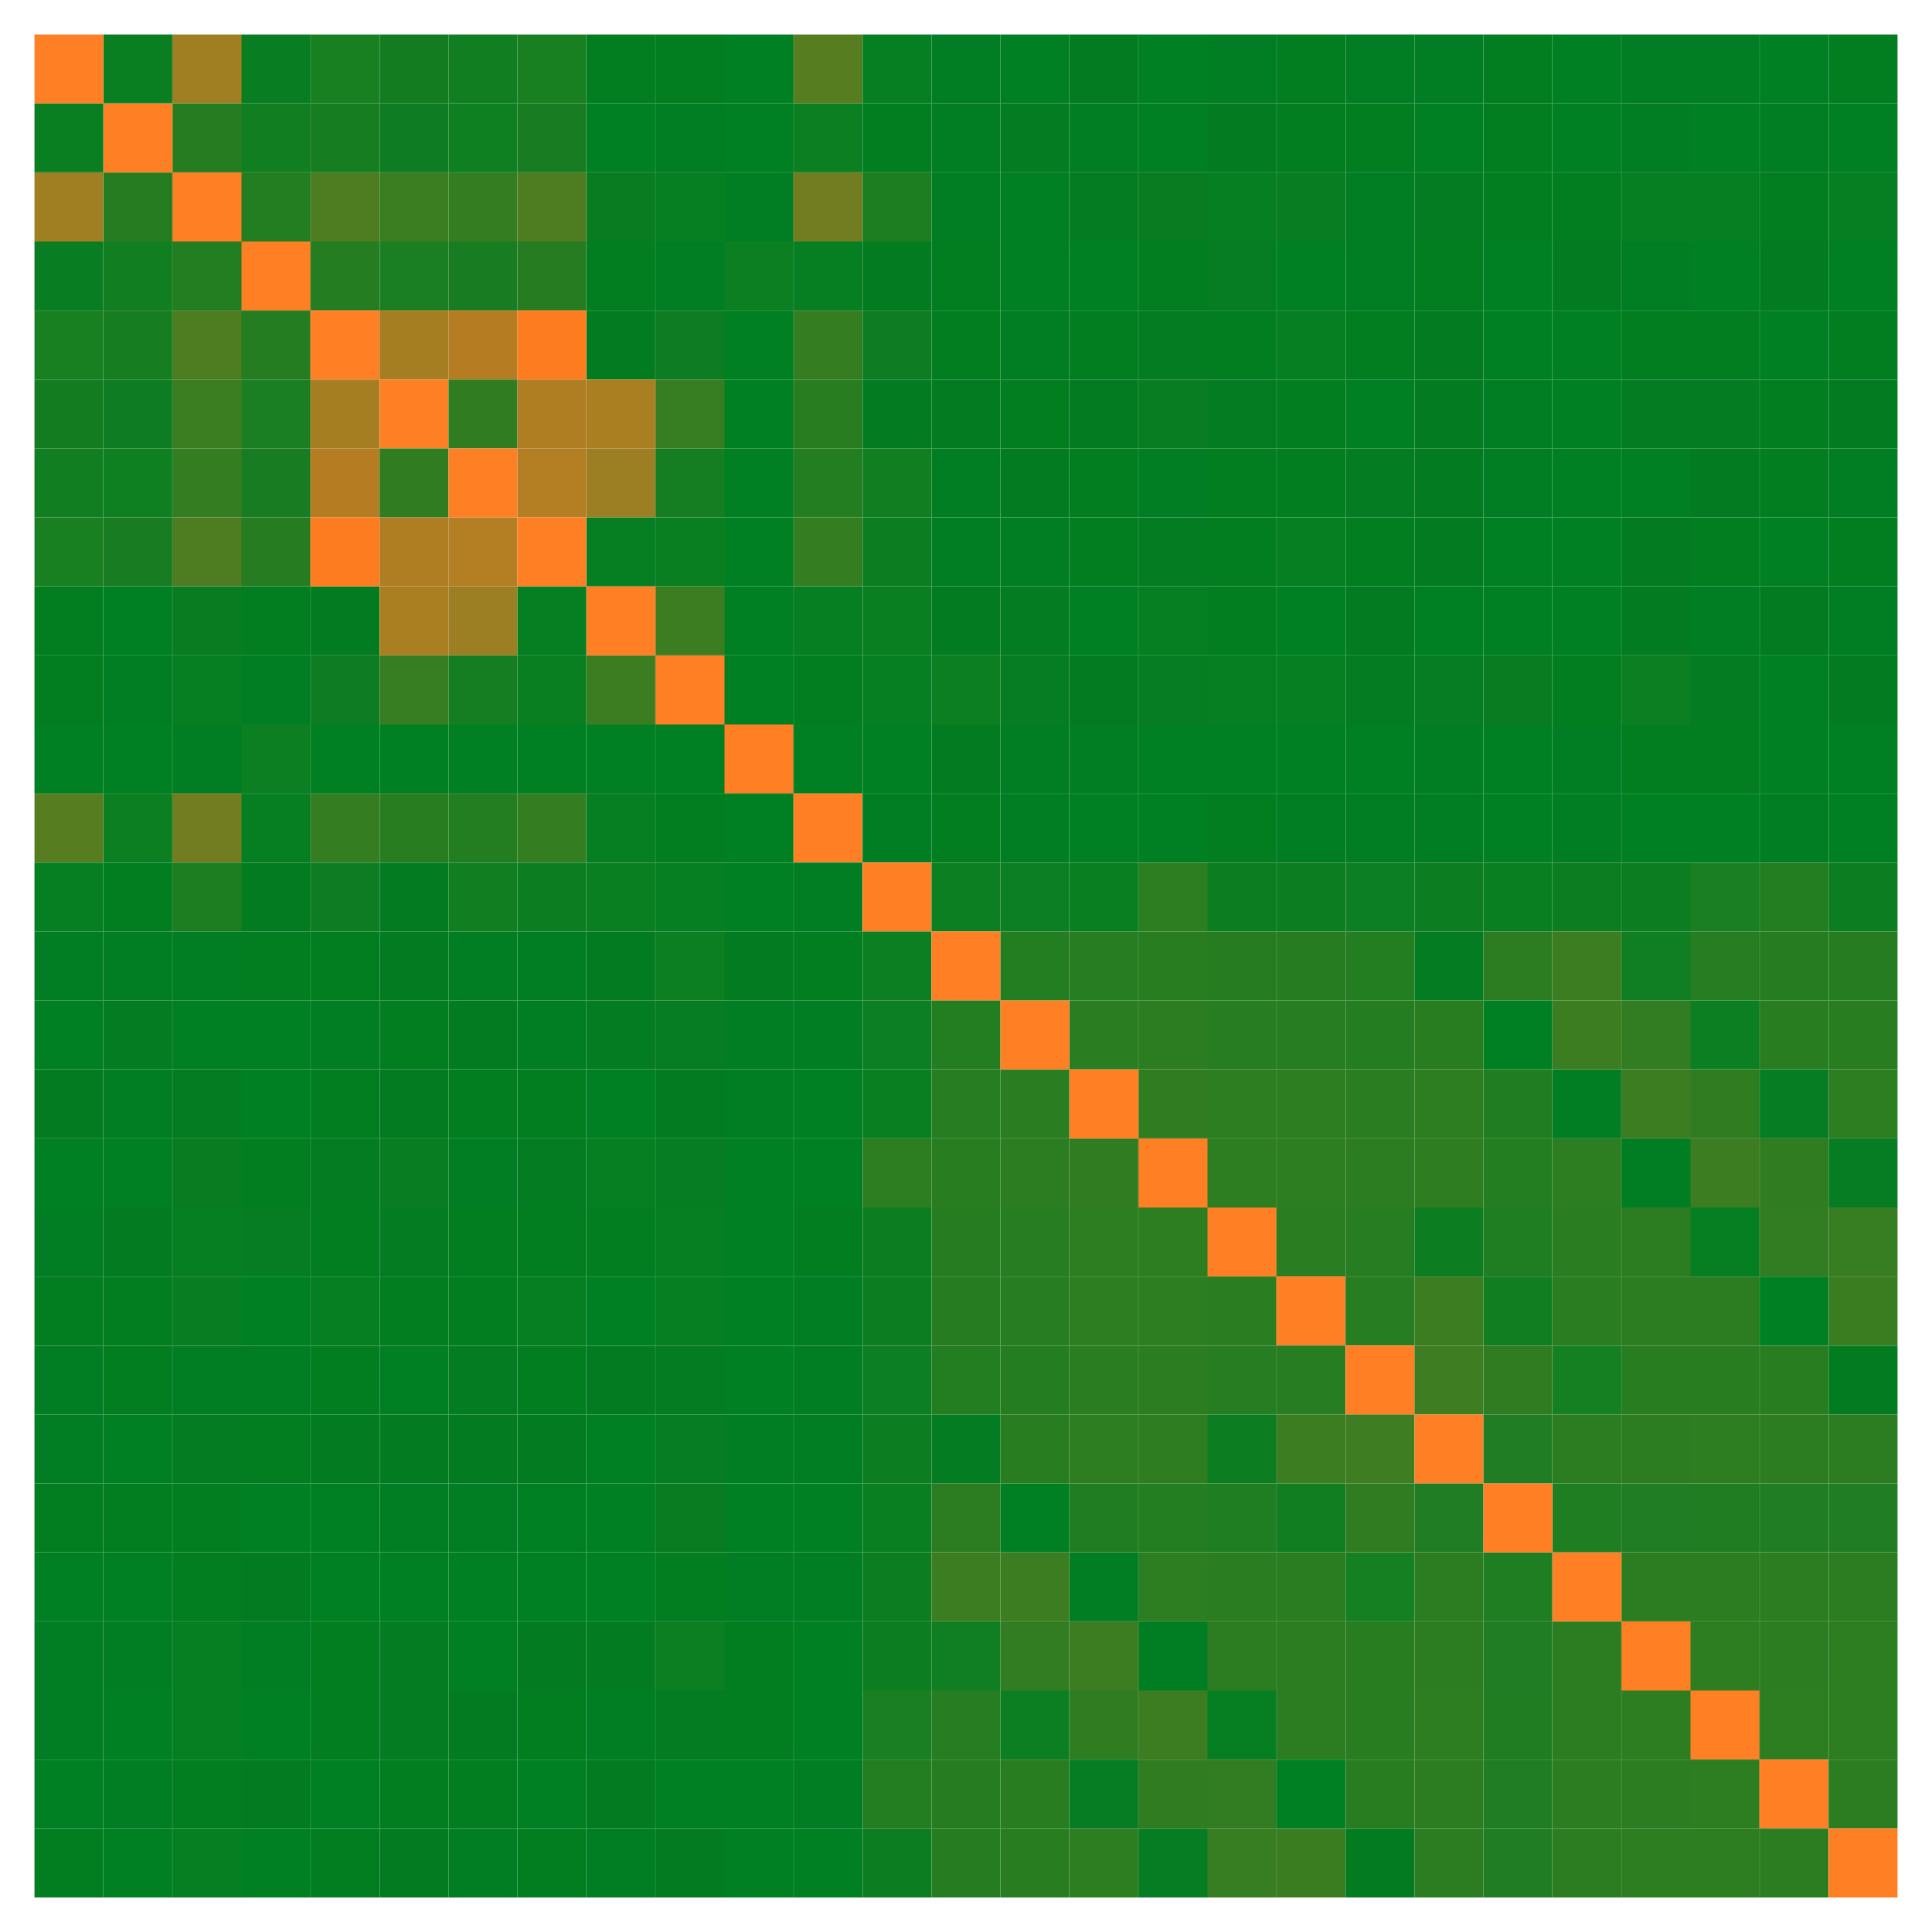

In [26]:
showPlot(heatmapPlot(coeff1))

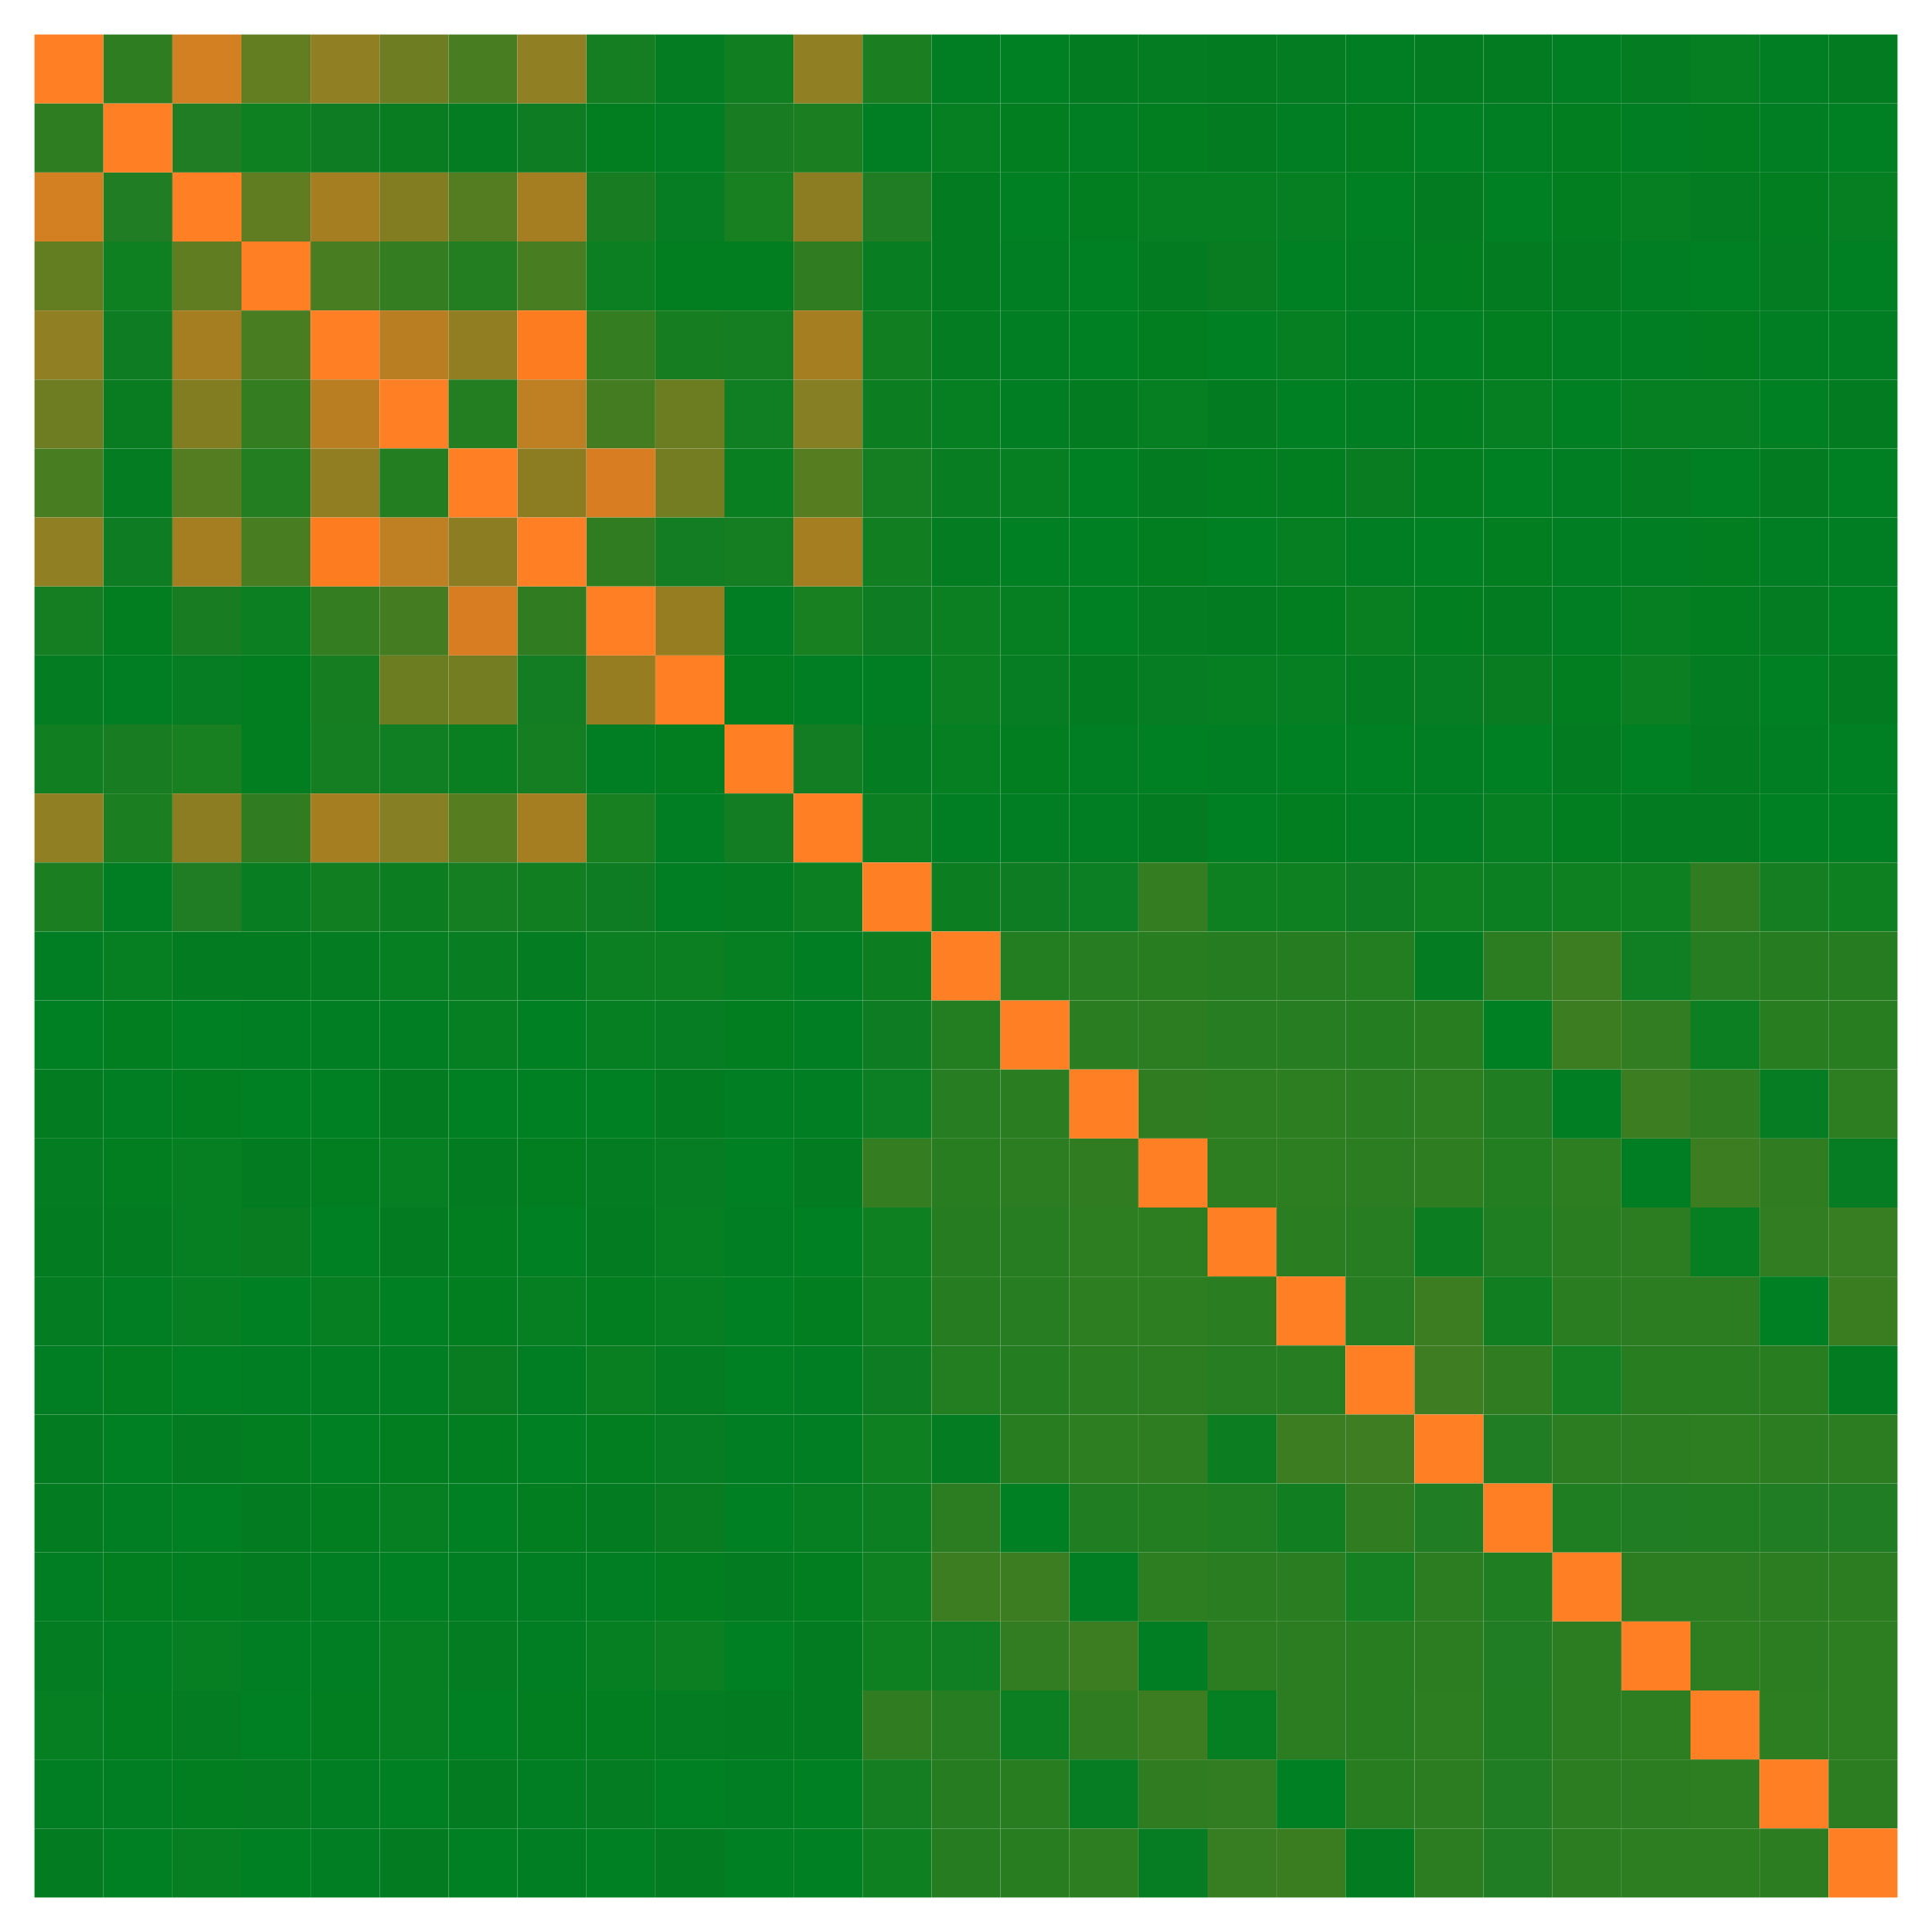

In [27]:
showPlot(heatmapPlot(coeff2))

### Выводы:
Видем явную кореляции commBase и comm24_1

# Скалируем значения

In [28]:
import org.apache.spark.ml.feature.StandardScaler

import org.apache.spark.ml.feature.StandardScaler

In [29]:
val scaler = new StandardScaler()
      .setInputCol("features")
      .setOutputCol("scaledFeatures")
      .setWithStd(true)
      .setWithMean(false)

scaler: StandardScaler = stdScal_d5a5844f4e09

In [30]:
val scalerModel = scaler.fit(df_features)

first at StandardScaler.scala:113

1 / 1

first at StandardScaler.scala:113

1 / 1

scalerModel: org.apache.spark.ml.feature.StandardScalerModel = StandardScalerModel: uid=stdScal_d5a5844f4e09, numFeatures=27, withMean=false, withStd=true

In [31]:
val df_scaled = scalerModel.transform(df_features)
df_scaled.showHTML(5)

take at cmd11.sc:4

1 / 1

likes,Checkins,Returns,Category,commBase,comm24,comm48,comm24_1,diff2448,baseTime,length,shares,hrs,sun_pub,mon_pub,tue_pub,wed_pub,thu_pub,fri_pub,sat_pub,sun_base,mon_base,tue_base,wed_base,thu_base,fri_base,sat_base,output,features,scaledFeatures
634995.0,0.0,463.0,1.0,0.0,0.0,0.0,0.0,0.0,65.0,166.0,2.0,24.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"(27,[0,2,3,9,10,1...","(27,[0,2,3,9,10,1..."
634995.0,0.0,463.0,1.0,0.0,0.0,0.0,0.0,0.0,10.0,132.0,1.0,24.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,"(27,[0,2,3,9,10,1...","(27,[0,2,3,9,10,1..."
634995.0,0.0,463.0,1.0,0.0,0.0,0.0,0.0,0.0,14.0,133.0,2.0,24.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"(27,[0,2,3,9,10,1...","(27,[0,2,3,9,10,1..."
634995.0,0.0,463.0,1.0,7.0,0.0,3.0,7.0,-3.0,62.0,131.0,1.0,24.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,"(27,[0,2,3,4,6,7,...","(27,[0,2,3,4,6,7,..."
634995.0,0.0,463.0,1.0,1.0,0.0,1.0,1.0,-1.0,32.0,157.0,2.0,24.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"(27,[0,2,3,4,6,7,...","(27,[0,2,3,4,6,7,..."


df_scaled: DataFrame = [likes: double, Checkins: double ... 28 more fields]

# Получим матрицу для Breeze

In [32]:
import breeze.linalg._
import breeze.numerics._

import breeze.linalg._

import breeze.numerics._

In [33]:
def getDenseMatrixFromDF(
    df:DataFrame,
    label:String,
    features:String,
    columns_features:Array[String]
    ):(DenseMatrix[Double],DenseMatrix[Double]) = {
       
    import org.apache.spark.ml.linalg.Vector
    val vecToArray = udf( (xs: Vector) => xs.toArray )
    
    val sqlExpr = columns_features.zipWithIndex.map{ case (alias, idx) => col(features).getItem(idx).as(alias)}

    val df_matrix = df.select(features).withColumn(features , vecToArray(col(features)) ).select(sqlExpr : _*)

    val featureArray:Array[Seq[Double]] = df_matrix.collect.map(_.toSeq.collect { case i: java.lang.Number => i.doubleValue() })
    
    val featureMatrix:DenseMatrix[Double] = DenseMatrix(featureArray:_*)
    
    val labelArray:Array[Seq[Double]] = df.select(label).collect.map(_.toSeq.collect { case i: java.lang.Number => i.doubleValue() })
    
    val labelMatrix:DenseMatrix[Double] = DenseMatrix(labelArray:_*)
    
    (featureMatrix, labelMatrix)
}

defined function getDenseMatrixFromDF

In [34]:
val (x, y) = getDenseMatrixFromDF(
    df=df_scaled,
    label=label,
    features="scaledFeatures",
    columns_features=columns_features
)

collect at cmd32.sc:15

1 / 1

collect at cmd32.sc:19

1 / 1

x: DenseMatrix[Double] = 0.0865520007909469   0.0  0.003905513570349724  ... (27 total)
0.0865520007909469   0.0  0.003905513570349724  ...
0.0865520007909469   0.0  0.003905513570349724  ...
0.0865520007909469   0.0  0.003905513570349724  ...
0.0865520007909469   0.0  0.003905513570349724  ...
0.211628668628961    0.0  0.5452619928746792    ...
0.211628668628961    0.0  0.5452619928746792    ...
0.211628668628961    0.0  0.5452619928746792    ...
0.211628668628961    0.0  0.5452619928746792    ...
0.211628668628961    0.0  0.5452619928746792    ...
0.211628668628961    0.0  0.5452619928746792    ...
0.211628668628961    0.0  0.5452619928746792    ...
0.211628668628961    0.0  0.5452619928746792    ...
0.211628668628961    0.0  0.5452619928746792    ...
0.211628668628961    0.0  0.5452619928746792    ...
0.211628668628961    0.0  0.5452619928746792    ...
0.211628668628961    0.0  0.5452619928746792    ...
0.211628668628961    0.0  0.5452619928746792    ...
0.211628668628961    0.0  0.

# Реализуем модель простой линейной регрессии, используя стандартные функции Breeze

In [35]:
def gradientDescent(
    x:DenseMatrix[Double],
    y:DenseMatrix[Double],
    theta:DenseMatrix[Double],
    alpha:Double,
    iters:Int) = {
    val m = x.rows.toDouble
    val xTrans = x.t
    var th = theta.copy
    var i = 0
    var result = -1.0
    while( i < iters ){
        var hypothesis = x*th.t
        var loss = hypothesis - y
        var cost = sum(pow(loss, 2)) / (2 * m)
        //println(s"Iteration $i | Cost: $cost")
        var gradient = (xTrans*loss)/m
        th = th - (alpha * gradient).t
        result = cost
        i+=1
    }
    
    (th, result)
}

defined function gradientDescent

In [36]:
val theta = DenseMatrix.ones[Double]( 1, x.cols)
val alpha = 0.0001
val iters = 10000

theta: DenseMatrix[Double] = 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ... (27 total)
alpha: Double = 1.0E-4
iters: Int = 10000

In [38]:
val (th, cost) = gradientDescent(
    x=x,
    y=y,
    theta=theta,
    alpha=alpha,
    iters=iters
)

th: DenseMatrix[Double] = 0.07802780476683224  0.15721614909263676  1.396303267543915  ... (27 total)
cost: Double = 445.69007646709116